Notebook structure to serve as a template for all other matches. Should read in data, synchronize event and tracking feeds then run pitch control for frames per event

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import os
import json
import numpy as np
import socceraction.spadl as spadl
import socceraction.xthreat as xthreat
import matplotsoccer as mps
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd
from kloppy import secondspectrum
import pickle
import sys
 
# setting path
sys.path.append('../')
 
# # importing
from src.second_spectrum_utils import get_home_away_tracking
import src.player_velocities as vel
import src.pitch_control as pc
import src.visualizations as viz

import src.statsbomb_util as sb

In [7]:
META_PATH = "../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312166_SecondSpectrum_meta.xml"
RAW_PATH = "../man-city-data/SecondSpectrum/MCI Women_s Files-001/g2312166_SecondSpectrum_tracking-produced.jsonl"
EVENT_PATH = "../man-city-data/StatsBomb/Data/ManCity_Liverpool_events.json"

PARAMS = pc.parameters()

In [8]:
dataset = secondspectrum.load(
    meta_data=META_PATH,
    raw_data=RAW_PATH,
    
    # Optional arguments
    sample_rate=1/1,
    coordinates="secondspectrum",
    only_alive=False)


In [9]:
home_df, away_df = get_home_away_tracking(dataset)
tracking_home = vel.calc_player_velocities(home_df,smoothing=True,filter_='moving_average')
tracking_away = vel.calc_player_velocities(away_df,smoothing=True,filter_='moving_average')

In [6]:
tracking_home

NameError: name 'tracking_home' is not defined

In [55]:
tracking_df = dataset.to_df()

In [56]:
tracking_df = tracking_df[['period_id','timestamp','frame_id','ball_state','ball_owning_team_id']]
tracking_df = tracking_df.rename(columns={'timestamp': 'time_sec'})

In [57]:
event_data = pd.read_json(EVENT_PATH)
event_df = sb.rename_cols(sb.normalize_dataframe(event_data))

In [58]:
event_df = sb.normalize_time_column(event_df)

In [59]:
event_df = event_df.dropna(subset = ['obv_total_net'])
event_df = event_df.loc[event_df['duration'] != 0]
event_df.head()

,event_id,index,period_id,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,pass_cut_back,foul_won_defensive,clearance_other,timestamp_shift,timediff,time
4,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.681949e+12,1.168,1.17
6,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.681949e+12,0.000,2.33
7,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.681949e+12,0.875,3.20
9,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.681949e+12,0.000,6.22
10,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.681949e+12,1.756,7.98


In [60]:
t1 = tracking_df[(tracking_df.period_id == 1)]
t2 = tracking_df[(tracking_df.period_id == 2) ]
e1 = event_df[(event_df.period_id == 1)]
e2 = event_df[(event_df.period_id == 2)]


In [61]:
merged_1 = pd.merge_asof(e1.sort_values('time'), t1.sort_values('time_sec'), 
                           left_on='time', right_on='time_sec', 
                           direction='nearest')
merged_2 = pd.merge_asof(e2.sort_values('time'), t2.sort_values('time_sec'), 
                           left_on='time', right_on='time_sec', 
                           direction='nearest')

merged_df = pd.concat([merged_1,merged_2])

In [73]:
merged_df = merged_df[merged_df["ball_state"]=="alive"]
merged_df['attacking_team'] = merged_df['team_id'].apply(lambda x: 'home' if x == 746 else 'away')
merged_df.frame_id.nunique()

1538

In [74]:
merged_df.head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,clearance_other,timestamp_shift,timediff,time,period_id_y,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team
0,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,NaN,1.681949e+12,1.168,1.17,1,1.16,29,alive,away,away
1,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,NaN,1.681949e+12,0.000,2.33,1,2.32,58,alive,away,away
2,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,NaN,1.681949e+12,0.875,3.20,1,3.20,80,alive,away,away
3,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,NaN,1.681949e+12,0.000,6.22,1,6.20,155,alive,away,away
4,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,NaN,1.681949e+12,1.756,7.98,1,8.00,200,alive,away,away


In [68]:
frame = 3756

attacking_team = tracking_df.loc[tracking_df.frame_id == frame, "ball_owning_team_id"].item().capitalize()
attacking_team

'Home'

c:\Users\MatthewMoore\source\personal_repos\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)


off ball expected threat: 1.2%


(<Figure size 1200x800 with 2 Axes>, <Axes: >)

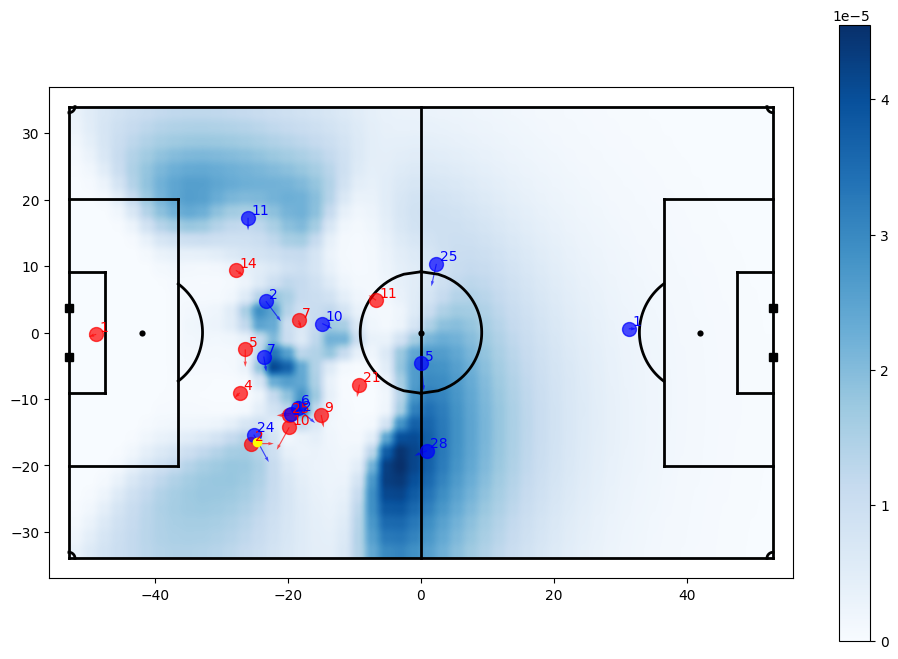

In [70]:
viz.plot_scoring_opp_for_frame(frame, tracking_home, tracking_away, "Away", PARAMS)

In [77]:
frames = []
value = []
control_matrix = []
for index, row in merged_df.iterrows():
    print(index)
    attacking_team = row["attacking_team"].capitalize()
    off_scoring, xgrid, ygrid = viz.generate_off_ball_scoring_opportunity_for_frame(row["frame_id"], tracking_home, tracking_away, attacking_team, PARAMS)
    control_matrix.append(off_scoring)
    frames.append(row["frame_id"])
    value.append(round(np.sum(off_scoring)))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
272
273
274
275
276
277
278
279
280
281
2

In [78]:
value_df = pd.DataFrame(
    {'frame': frames,
     'value': value,
     'conrol_matrix': control_matrix
    })

In [96]:
value_df.head()

,frame,value,conrol_matrix
0,29,0,"[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734..."
1,58,0,"[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ..."
2,80,0,"[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ..."
3,155,0,"[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1...."
4,200,0,"[[0.0, 0.0, 4.232596730897403e-16, 2.127868640..."


In [82]:
merged_df.columns

Index(['event_id', 'index', 'period_id_x', 'timestamp', 'minute', 'second',
       'possession', 'obv_for_after', 'obv_for_before', 'obv_for_net',
       ...
       'clearance_other', 'timestamp_shift', 'timediff', 'time', 'period_id_y',
       'time_sec', 'frame_id', 'ball_state', 'ball_owning_team_id',
       'attacking_team'],
      dtype='object', length=149)

In [83]:
full_df = pd.merge(merged_df, value_df, left_on='frame_id', right_on='frame')

In [84]:
full_df.head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time,period_id_y,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix
0,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,1.17,1,1.16,29,alive,away,away,29,0,"[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734..."
1,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,2.33,1,2.32,58,alive,away,away,58,0,"[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ..."
2,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,3.20,1,3.20,80,alive,away,away,80,0,"[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ..."
3,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,6.22,1,6.20,155,alive,away,away,155,0,"[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1...."
4,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,7.98,1,8.00,200,alive,away,away,200,0,"[[0.0, 0.0, 4.232596730897403e-16, 2.127868640..."


In [85]:
full_df.to_pickle('merged_df.pkl')


In [95]:
full_df.head()

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time,period_id_y,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix
0,9e527a78-b536-45c7-8129-b7130170f7e1,5,1,1681948801168,0,1,2,0.015598,0.006829,0.008769,...,1.17,1,1.16,29,alive,away,away,29,0,"[[0.0, 0.0, 0.0, 1.175143364150473e-15, 9.4734..."
1,b9899f6f-5587-46aa-9f9e-e2f9823e55a5,7,1,1681948802329,0,2,2,0.015397,0.015598,-0.000201,...,2.33,1,2.32,58,alive,away,away,58,0,"[[0.0, 0.0, 0.0, 0.0, 2.2664500598432182e-15, ..."
2,de84d7e8-6b96-476c-a928-6d59c2326295,8,1,1681948803204,0,3,2,0.010824,0.015397,-0.004573,...,3.20,1,3.20,80,alive,away,away,80,0,"[[0.0, 0.0, 0.0, 0.0, 2.5047423063273324e-16, ..."
3,632a16b5-6e82-450b-9895-f9a1b776af21,10,1,1681948806225,0,6,2,0.011461,0.010824,0.000637,...,6.22,1,6.20,155,alive,away,away,155,0,"[[0.0, 0.0, 0.0, 0.0, 2.46901209304493e-16, 1...."
4,ed6e3229-fa69-4897-bde3-60660e745664,11,1,1681948807981,0,7,2,0.010457,0.011461,-0.001004,...,7.98,1,8.00,200,alive,away,away,200,0,"[[0.0, 0.0, 4.232596730897403e-16, 2.127868640..."


In [133]:
shots = full_df[full_df.type_name == "Shot"]
row = shots.iloc[8]
row

event_id                            a3ae7c33-4991-411f-9899-13ba7844af6a
index                                                               1602
period_id_x                                                            2
timestamp                                                  1681948853577
minute                                                                45
                                             ...                        
ball_owning_team_id                                                 home
attacking_team                                                      home
frame                                                              70383
value                                                                  0
conrol_matrix          [[1.4717295889968626e-05, 1.7635658067545717e-...
Name: 805, Length: 152, dtype: object

In [3]:
import pickle

with open("merged_df.pkl", 'rb') as f:
    full_merged = pickle.load(f)

In [14]:
row = full_merged.iloc[81]
row

event_id                            5e0b5664-afab-4ff3-b3e4-db9afc3e7320
index                                                                148
period_id_x                                                            1
timestamp                                                  1681948989560
minute                                                                 3
                                             ...                        
ball_owning_team_id                                                 home
attacking_team                                                      home
frame                                                               4739
value                                                                  0
conrol_matrix          [[8.743627165289358e-08, 1.0176112047765754e-0...
Name: 81, Length: 152, dtype: object

c:\Users\MatthewMoore\source\personal_repos\City-DS\notebooks\..\src\visualizations.py:164: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(hometeam['ball_x'], hometeam['ball_y'], 'ko', color="yellow", markersize=6, alpha=1.0, linewidth=0)


home Pass


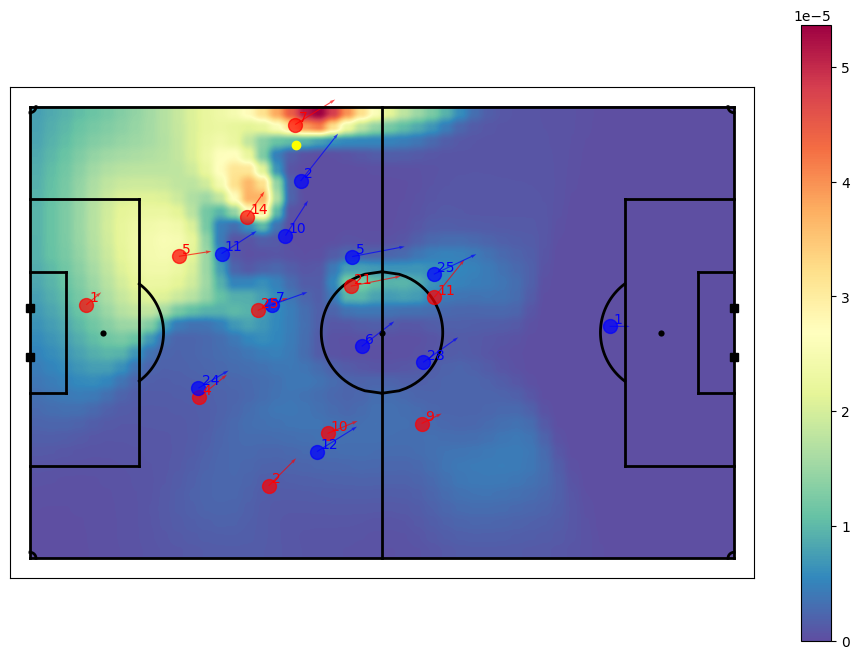

In [15]:
viz.plot_frame_players(row.frame, tracking_home, tracking_away, row.attacking_team, row.conrol_matrix)
print(row.attacking_team, row.type_name)

In [4]:
full_merged.to_csv("mergedtest.csv")

In [11]:
h1 = full_merged[(full_merged.attacking_team == "home") & (full_merged.period_id_x == 1)]


In [12]:
h1

,event_id,index,period_id_x,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,time,period_id_y,time_sec,frame_id,ball_state,ball_owning_team_id,attacking_team,frame,value,conrol_matrix
13,1a2556a7-bfee-4fe5-b9f0-495198e5c727,26,1,1681948827838,0,27,2,0.011697,0.011673,0.000024,...,27.84,1,27.84,696,alive,home,home,696,0,"[[9.138079737072616e-07, 1.1094027393470686e-0..."
18,3dd94df6-60a4-4e71-8415-b5953a62c65e,35,1,1681948838037,0,38,3,0.021999,0.031385,-0.009386,...,38.04,1,38.04,951,alive,home,home,951,0,"[[2.0793188977374242e-07, 2.7208678599041676e-..."
19,41cc98e0-5b23-47a6-a558-78d18f57af79,37,1,1681948838746,0,38,3,0.030666,0.021999,0.008667,...,38.75,1,38.76,969,alive,home,home,969,0,"[[1.4896853687005017e-07, 1.9708559893157413e-..."
20,5ccd8aba-089d-4342-9712-47c27c8d639f,39,1,1681948841707,0,41,3,0.027067,0.030666,-0.003599,...,41.71,1,41.72,1043,alive,home,home,1043,0,"[[4.720498503169481e-08, 6.561138674828859e-08..."
21,9e8d7a75-1850-4b91-bdb2-6f079e35bab2,41,1,1681948842707,0,42,3,0.025076,0.027067,-0.001991,...,42.71,1,42.72,1068,alive,home,home,1068,0,"[[4.118347947275183e-08, 5.7396070063256866e-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,4df65747-350b-4350-8862-d42b873eb811,1517,1,1681951521624,45,21,94,0.010070,0.009080,0.000990,...,2721.62,1,2721.60,68040,alive,away,home,68040,0,"[[1.1158117453238915e-06, 1.049296721785582e-0..."
780,6e2790b3-38ec-488c-ad43-f5d245ceebd9,1539,1,1681951549021,45,49,94,0.008983,0.005631,0.003352,...,2749.02,1,2749.00,68725,alive,away,home,68725,0,"[[3.1992554388935168e-06, 3.820801453208357e-0..."
782,35c5e3d3-3397-491c-b673-d3a8d338dc1e,1545,1,1681951552137,45,52,95,0.013299,0.014239,-0.000940,...,2752.14,1,2752.12,68803,alive,away,home,68803,0,"[[2.340851679771697e-06, 2.6415876330091337e-0..."
783,aad2d380-c931-48dc-a1ac-beee7784b905,1546,1,1681951555679,45,55,95,0.010577,0.013299,-0.002722,...,2755.68,1,2755.68,68892,alive,home,home,68892,0,"[[8.18691431775556e-06, 9.362057652828632e-06,..."
